In [1]:
# Consolidated bunch of tutorials including:
#     - Opening PACE V2 land products (srfl, vis)
#     - Bitmasking
#     - Converting L2s to GIS compatible format
#     - Exporting as GeoTIFF

#### Summary

This notebook will explore how to handle PACE data, including opening and visualizing PACE land products, masking those products, converting them to GIS compatible format, and exporting them as a geotiff.


#### Learning objectives

By the end of this notebook you will be able to:
- Open PACE OCI land products with python
- Mask those products for features you want to exclude from your analysis that are flagged in the data
- Convert level 2 OCI data to a GIS compatible format
- Export those GIS compatible data as a GeoTIFF
  


#### Contents
1. [Open Terrestrial PACE Data in Python](#1.-Open-Terrestrial-PACE-Data-in-Python)
2. [Mask Data for Clouds and Water](#2.-Mask-Data-for-Clouds-and-Water)
3. [GIS Compatibility](#3.-GIS-Compatibility)
4. [Convert netCDF to GeoTIFF Format](#4.-Convert-netCDF-to-GeoTIFF-Format)
   
-------



#### 1. Open Terrestrial PACE Data in Python

The first thing to do is import all the necessary libraries used in this notebook. For a more detailed explanation on setting up your environment, follow the guidance on the [tutorials] page. 

[tutorials]: https://oceancolor.gsfc.nasa.gov/resources/docs/tutorials/

In [2]:
# Import relevant libraries
import os
import numpy as np 
import xarray as xr
import cartopy.crs as ccrs 
import matplotlib.pyplot as plt 
from os.path import join

Now we can open some data and visualize it. This tutorial will focus on only very simple one-channel visualizations - for RGB representations of the data, see the [Satellite Data Visualization] tutorial. Define the path to a pre-downloaded L2 file (NOTE: Earthaccess does not have access to terrestrial stuff right now, so won't be able to use the tutorial without downloading a file. Hopefully this changes soon!), and use `xarray` to open it: 

[Satellite Data Visualization]: https://pacehackweek.github.io/pace-2024/presentations/hackweek/satdata_visualization.html#2.-Easy-Global-Chlorophyll-a-Map

In [3]:
# Define your file path
file_path = "/Users/sacaplan/Projects/ilw/data/glakes_0701/"
file_name_L2 = "PACE_OCI.20240701T175112.L2.SFREFL.V2_0.NRT.nc"

# Merge to carry lat/lon data with surface reflectances
ds_geo = xr.open_dataset(join(file_path, file_name_L2), group='geophysical_data')        # Open group with rhos
ds_nav = xr.open_dataset(join(file_path, file_name_L2), group='navigation_data')         # Open group with lat/lon info
ds = xr.merge((ds_geo, ds_nav))                                                          # Merge
ds = ds.set_coords(('latitude', 'longitude'))                                            # Set lat & lon as coordinates, not variables
ds

<xarray.Dataset>
Dimensions:    (number_of_lines: 1710, pixels_per_line: 1272, wavelength_3d: 50)
Coordinates:
    longitude  (number_of_lines, pixels_per_line) float32 ...
    latitude   (number_of_lines, pixels_per_line) float32 ...
Dimensions without coordinates: number_of_lines, pixels_per_line, wavelength_3d
Data variables:
    rhos       (number_of_lines, pixels_per_line, wavelength_3d) float32 ...
    l2_flags   (number_of_lines, pixels_per_line) int32 ...
    tilt       (number_of_lines) float32 ...

In the above print-out of our L2 file, we see the data variables `rhos` and `l2_flags`. The `rhos` variable are our surface reflectances, and the `l2_flags` are quality flags as defined by the [Ocean Biology Processing Group].

We can also see which wavelengths the surface reflectances correspond to by opening the `sensor_band_parameters` group of the same netCDF file:

[Ocean Biology Processing Group]:https://oceancolor.gsfc.nasa.gov/resources/atbd/ocl2flags/

In [4]:
# Wavelengths of each rhos band are also included in the netcdf file:
ds_sbp = xr.open_dataset(join(file_path, file_name_L2), group='sensor_band_parameters')  # Open group with wavelength info
ds_wls = ds_sbp.wavelength_3d
ds_wls.values

array([ 339.,  353.,  368.,  380.,  388.,  400.,  415.,  425.,  440.,
        465.,  470.,  485.,  495.,  515.,  530.,  537.,  550.,  555.,
        563.,  570.,  588.,  601.,  610.,  625.,  635.,  645.,  650.,
        662.,  670.,  679.,  686.,  691.,  698.,  706.,  711.,  727.,
        746.,  758.,  771.,  799.,  814.,  837.,  860.,  875.,  882.,
       1038., 1249., 1618., 2131., 2258.])

Now that the xarray dataset object contains both the quantity we're interested in and the location of each pixel in space, we can map the data using `cartopy`. Below is an example plot of the surface reflectance at 555 nm:

Text(0.5, 1.0, 'Surface reflectance at 555.0 nm')

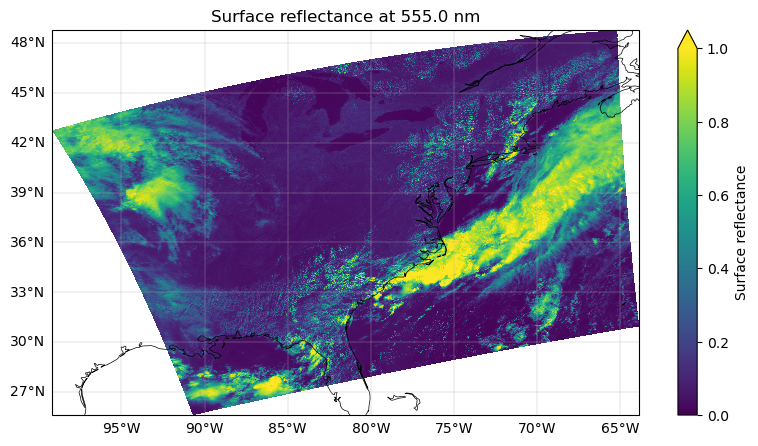

In [5]:
# Find wavelength of interest
wl = np.argwhere(ds_wls.values == 555.)[0][0]

# Map the data
fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.5)
ax.gridlines(draw_labels={"left": "y", "bottom": "x"},linewidth=0.25)
ds.rhos[:,:,wl].plot(x='longitude', y='latitude', cmap='viridis', vmin=0, vmax=1.0)
ax.set_title(f'Surface reflectance at {ds_wls.values[wl]} nm')

Great! We've plotted the surface reflectance at a single band for the whole scene. However, there are some clouds in this image that we want to exclude from our analysis. 

### 2. Mask for Clouds and Water

When we looked at the ```ds``` xarray object earlier, you might have noticed the variable ```l2_flags```. Let's look more closely at that variable.

In [6]:
ds.l2_flags

<xarray.DataArray 'l2_flags' (number_of_lines: 1710, pixels_per_line: 1272)>
[2175120 values with dtype=int32]
Coordinates:
    longitude  (number_of_lines, pixels_per_line) float32 ...
    latitude   (number_of_lines, pixels_per_line) float32 ...
Dimensions without coordinates: number_of_lines, pixels_per_line
Attributes:
    long_name:      Level-2 Processing Flags
    valid_min:      -2147483648
    valid_max:      2147483647
    flag_masks:     [          1           2           4           8         ...
    flag_meanings:  ATMFAIL LAND PRODWARN HIGLINT HILT HISATZEN COASTZ SPARE ...

```l2_flags``` is in the same shape as the surface reflectance we plotted above, but plotting the variable doesn't seem to give us any information. That's because ```l2_flags``` is actually a 2D array of numbers representing bitflags, so they must be treated as bits and not numbers. The meaning of each flag is described [here](https://oceancolor.gsfc.nasa.gov/resources/atbd/ocl2flags/). 

For example, in the surface reflectance plot above, say we want to mask clouds. Instead of trying to do some threshold math or applying your own cloud mask algorithm to each pixel, you can use the ```l2_flags``` variable and use L2gen's cloud mask (CLDICE) instead. Using the reference link above to figure out what bit represents clouds:

In [7]:
# CLDICE is position 09
# Ref: https://oceancolor.gsfc.nasa.gov/resources/atbd/ocl2flags/
bit_position = 9
cloudmasked_ds = ds.where(~((ds.l2_flags & (1 << bit_position)) != 0))

The masked dataset ```cloudmasked_ds``` will retain the structure and information contained in the original merged dataset, but will take pixels where the 9th bit is flipped and assign them as NaNs. We can plot the data again to see what has changed:

Text(0.5, 1.0, 'Surface reflectance at 555 nm with cloud mask')

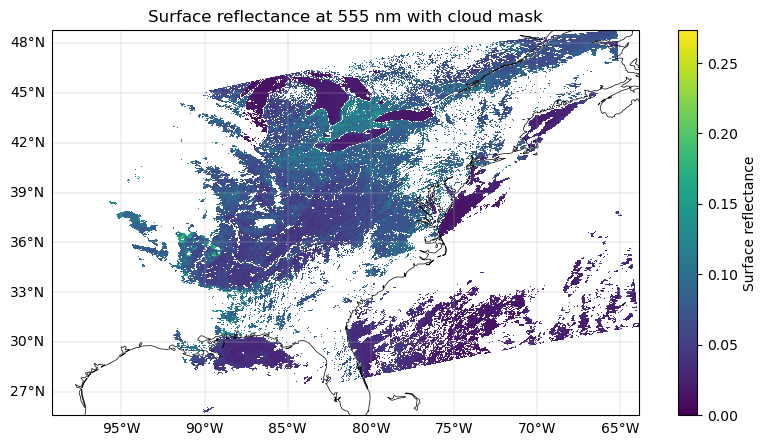

In [8]:
# Now, plot the masked dataset
fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.5)
ax.gridlines(draw_labels={"left": "y", "bottom": "x"},linewidth=0.25)
cloudmasked_ds.rhos[:,:,17].plot(x='longitude', y='latitude', cmap='viridis', vmin=0)
ax.set_title('Surface reflectance at 555 nm with cloud mask')

To see why this works, let's break down the one line of code which performs the masking. 

Each bit in a bitmask represents a specific condition or flag (in the above example, clouds). 
 - The ```(1 << bit position)``` portion of the code isolates the specific "bit" in the bitmask, or in other words the specific condition you want flagged. 
Since clouds are at bit position 9, we set ```bit_position``` to 9 in the example above.
 - ```ds.l2_flags``` is the variable in our xarray dataset that contains the values for each pixel of the bitmask.
 - ```ds.l2_flags & (1 << bit_position)``` is basically saying to look only for pixels in the l2_flag variable where the specified bit is set. In other words, to look for pixels that have been flagged as a cloud.
 - ```~(ds.l2_flags & (1 << bit_position) != 0)```: The statement within the parentheses, with ```!= 0```, evaluates any pixel with the cloud flag flipped as ```True```. Adding the ```~``` negates that condition, so that any pixel with the cloud bit set is evaluated to ```False```. We need these pixels to be False for the next step:
 - ```ds.where(~(ds.l2_flags & (1 << bit_position) != 0))```: ```xarray```'s ```.where``` function applies the mask to the entire dataset, which contains our surface reflectances. It keeps the pixel values which were evaluated to ```True``` in the step above, and assigns anything ```False``` as NaN.

We can apply multiple masks to the same datasets as well. Say you wanted to mask for clouds AND water, at the same time. Since there's not a water mask, we'll have to use the land mask and invert it so that we keep any pixels labelled "land":

Text(0.5, 1.0, 'Surface reflectance at 555 nm with cloud & water mask')

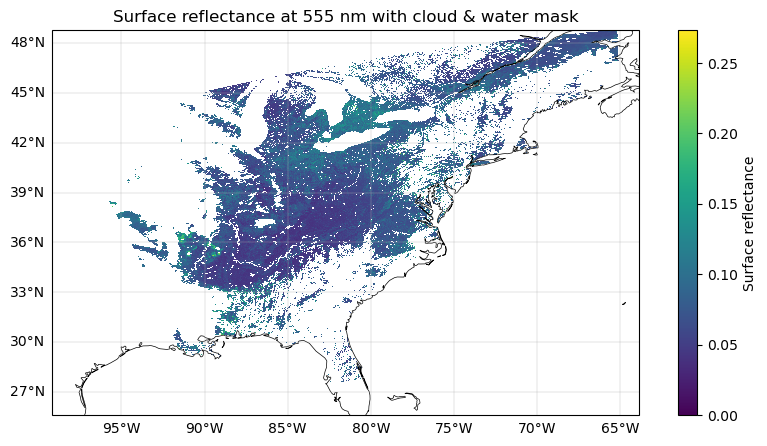

In [9]:
# Use the ~ for bit_position 9 (clouds), but omit it for bit_position 1 (land)
# This will ensure pixels with bit 1 set are kept, not masked
masked_ds = ds.where(~((ds.l2_flags & (1 << 9)) != 0) & ((ds.l2_flags & (1 << 1)) != 0))

fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.5)
ax.gridlines(draw_labels={"left": "y", "bottom": "x"},linewidth=0.25)
masked_ds.rhos[:,:,17].plot(x='longitude', y='latitude', cmap='viridis', vmin=0)
ax.set_title('Surface reflectance at 555 nm with cloud & water mask')

#### Alternative method: xarray's masking capabilities

```xarray```'s ```cf_xarray``` package can read flags as masks as well. This functionality has only been lightly tested, but should work for simple applications like we show below. See the [cf_xarray flag documentation](https://cf-xarray.readthedocs.io/en/latest/flags.html) here for more information.

There are certain requirements our `xarray` dataset `ds` must meet in order to be used with `cf_xarray`. First, we need to make sure the package can read the flags properly so we can eventually apply them to the data. `ds` currently contains srfl, flags, and geolocation information, so let's check that the flag variable is read as such with `cf_xarray`'s built in check:

In [18]:
# Import the package
import cf_xarray

# If we run the check to make sure l2_flags is a flag variable, we get an affirmative response, but we also can't print the flags to know what they are
print('Is l2_flags a flag variable?: ', ds.l2_flags.cf.is_flag_variable)

# Trying to print out the flags with xarray will return an error (something is wrong with the pretty print)
# But, the flags are still useable. 
#ds.l2_flags.cf

Is l2_flags a flag variable?:  True


The above statement shows the package recognizes `l2_flags`. The next step is to apply those flags, similar to the bitmask method. Xarray makes it easier by using the `where` function, and you don't have to understand bitwise operators to use it:

Text(0.5, 1.0, 'Surface reflectance at 17 nm with cloud & water mask')

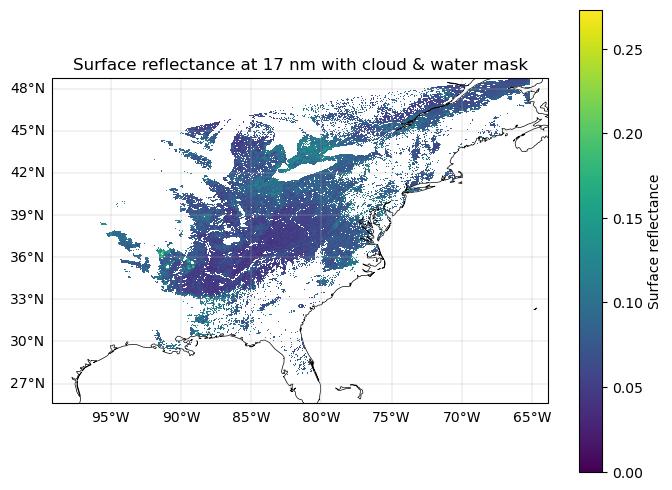

In [12]:
# Apply the mask to our original dataset ds
# Just remember we want to mask clouds, so must set them to NaN's with the ~
cldwater_mask = (ds.l2_flags.cf == 'LAND') & ~(ds.l2_flags.cf == 'CLDICE')
land_values = ds.where(cldwater_mask)

# Now, plot the masked data
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.5)
ax.gridlines(draw_labels={"left": "y", "bottom": "x"},linewidth=0.25)
land_values.rhos[:,:, wl].plot(x='longitude', y='latitude', cmap='viridis', vmin=0)
ax.set_title(f'Surface reflectance at {wl} nm with cloud & water mask')

Now that we have our surface reflectance data masked, we have multiple options for analysis. If your preferred data analysis environment is python, great! You can stop here. If you'd prefer to use an analysis software, specifically QGIS, you'll have to go through a couple more steps. 

### 3. GIS Compatibility

We've already imported the packages and manipulated the data as necessary for this part of the tutorial in the cells above, but if you've skipped to this section, just uncomment the code in the cell below to be all caught up. Also, please note that this method has only been tested with QGIS, not Arc or ArcPro. 

Let's take a look at the the ```masked_ds``` xarray object:

In [13]:
#import numpy as np
#import xarray as xr

# TODO: Change file paths
#file_path = "/Users/sacaplan/Documents/sat_data/pace/glakes_0701"
#file_name_L2 = "PACE_OCI.20240701T175112.L2.SFREFL.V2_0.NRT.nc"

# Merge to carry lat/lon data with surface reflectances
#ds_geo = xr.open_dataset(join(file_path, file_name_L2), group='geophysical_data')
#ds_nav = xr.open_dataset(join(file_path, file_name_L2), group='navigation_data')

#ds = xr.merge((ds_geo, ds_nav))
#ds = ds.set_coords(('latitude', 'longitude'))

# Mask the dataset for clouds and water
#masked_ds = ds.where(~((ds.l2_flags & (1 << 9)) != 0) & ((ds.l2_flags & (1 << 1)) != 0))

# Take a look at the masked dataset
masked_ds

<xarray.Dataset>
Dimensions:    (number_of_lines: 1710, pixels_per_line: 1272, wavelength_3d: 50)
Coordinates:
    longitude  (number_of_lines, pixels_per_line) float32 -90.68 ... -65.21
    latitude   (number_of_lines, pixels_per_line) float32 25.62 25.64 ... 48.76
Dimensions without coordinates: number_of_lines, pixels_per_line, wavelength_3d
Data variables:
    rhos       (number_of_lines, pixels_per_line, wavelength_3d) float32 nan ...
    l2_flags   (number_of_lines, pixels_per_line) float64 nan nan ... 34.0 34.0
    tilt       (number_of_lines, pixels_per_line) float32 nan nan ... 19.88

Since PACE data is hyperspectral, we're working with a 3D array of reflectances. We have dimensions 'number_of_lines' (rows, or our 'y' variable), 'pixels_per_line' (columns, or our 'x' variable), and wavelength_3d, which is an array of wavelengths in our hyperspectral data cube. The dimensions are in this *exact* order, so when we load a L2 surface reflectance file into QGIS, it looks like this:


<div>
<img src="imgs/QGIS_srfl_initial.png" width="500"/>
</div>

Because of the way PACE data orders its dimensions - that is, with ```number_of_lines``` first - QGIS reads that as the dimension we're interested in looking at. There's a simple way to fix this so that instead of reading the y variable, QGIS will show us the surface reflectance, our actual variable of interest. 

All we have to do to fix this is to transpose our dataset. Thankfully, xarray has this capability as well

In [14]:
# Use the transpose function to order the dimensions by wavlength, row, column
transposed_file = masked_ds.transpose("wavelength_3d", "number_of_lines", "pixels_per_line")
transposed_file

<xarray.Dataset>
Dimensions:    (number_of_lines: 1710, pixels_per_line: 1272, wavelength_3d: 50)
Coordinates:
    longitude  (number_of_lines, pixels_per_line) float32 -90.68 ... -65.21
    latitude   (number_of_lines, pixels_per_line) float32 25.62 25.64 ... 48.76
Dimensions without coordinates: number_of_lines, pixels_per_line, wavelength_3d
Data variables:
    rhos       (wavelength_3d, number_of_lines, pixels_per_line) float32 nan ...
    l2_flags   (number_of_lines, pixels_per_line) float64 nan nan ... 34.0 34.0
    tilt       (number_of_lines, pixels_per_line) float32 nan nan ... 19.88

Now we can see that ```rhos``` has the correct dimension order: wavelength, row, column. We can export this new set up using `xarray` again:

In [19]:
output_path = "/Users/sacaplan/Documents/applications/gis_notebook/PACE_OCI.20240701T175112.L2.SFREFL.V2_0.Transposed.nc"
transposed_file.to_netcdf(path=output_path)

If we load that new file into QGIS, we see that now wavelength is the dimension that varies! Remember that these data are still in the instrument swath and have not been projected to any coordinate system yet.

<div>
<img src="imgs/qgis_srfl_rgb.png" width="500"/>
</div>

We're finally close to being done! If you're fine working with netCDF format, you could stop here. The final thing we'll take you through is how to convert netCDF to a GeoTIFF format.

### 4. Convert netCDF to GeoTIFF format
For this process, we'll need one additional package called ```GDAL```. Note that the output file will not be georeferenced.

In [16]:
# Rioxarray not working (geo part not right and not exporting) so try gdal?
from osgeo import gdal, osr

outtiff = "PACE_OCI.20240701T175112.L2.SFREFL.V2_0.NRT.tif"
rhos_gdal = gdal.Open(f'NETCDF:\"{output_path}\":rhos')

driver = gdal.GetDriverByName("GTiff")
tf = driver.CreateCopy(outtiff, rhos_gdal, 0)

rhos_gdal = None
tf = None

/Users/sacaplan/mambaforge/envs/isofit_env/lib/python3.10/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
Warning 1: No 1D variable is indexed by dimension wavelength_3d
